In [579]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, rfft, fftfreq, rfftfreq
import os, re
# os.chdir("/home")


---
Reading data from three different flights (with the first file containing concatenated data from two flights)


In [580]:
data_15 = pd.read_csv('data/gyro_acc_lot_03_15.csv')
data_good_1 = pd.read_csv('data_new/lot_1_all_good.csv')
data_good_2 = pd.read_csv('data_new/lot_2_all_good.csv')
data_bad_1 = pd.read_csv('data_new/lot_3_not_good.csv')
data_bad_2 = pd.read_csv('data_new/lot_4_not_good.csv')

In [581]:
data_good_1.head()

,timestamp(ms),degrees(IMU[0].GyrX),degrees(IMU[0].GyrY),degrees(IMU[0].GyrZ),sqrt(IMU[0].AccX**2+IMU[0].AccY**2+IMU[0].AccZ**2)
0,357822.206,0.071552,-0.019053,0.030141,9.831911
1,357922.206,0.008173,0.003865,0.035543,9.834303
2,358022.206,0.024161,-0.059457,0.038191,9.832913
3,358122.206,0.064316,-0.022591,0.034253,9.832705
4,358222.206,0.086115,-0.014719,0.028690,9.839191


---
Verifying the obtained data; this file contains data from a flight with healthy rotor blades and one with a 1.5 cm damage.

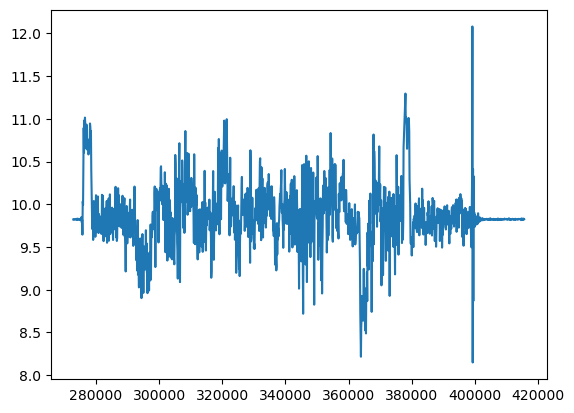

In [582]:
plt.plot(data_good_2['timestamp(ms)'],data_good_2['sqrt(IMU[0].AccX**2+IMU[0].AccY**2+IMU[0].AccZ**2)'])
plt.show()

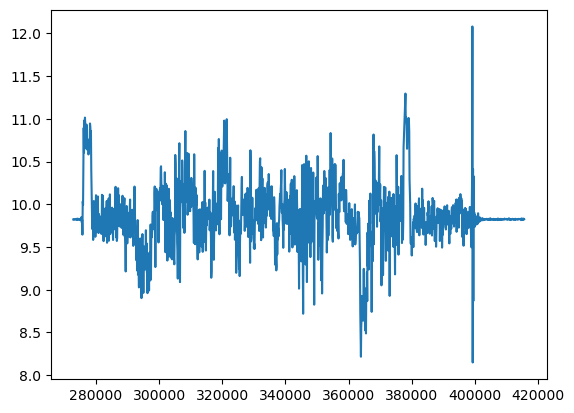

In [583]:
plt.plot(data_good_2['timestamp(ms)'],data_good_2['sqrt(IMU[0].AccX**2+IMU[0].AccY**2+IMU[0].AccZ**2)'])
plt.show()

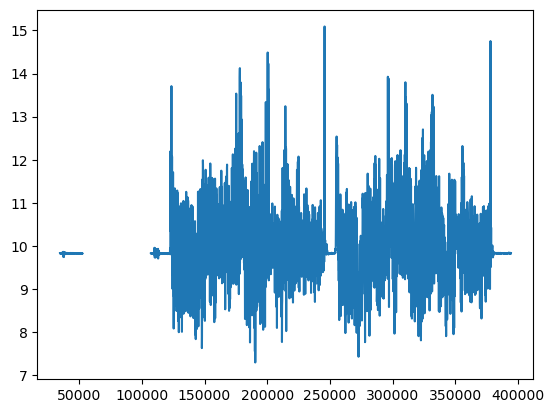

In [584]:
plt.plot(data_bad_2['timestamp(ms)'],data_bad_2['sqrt(IMU[0].AccX**2+IMU[0].AccY**2+IMU[0].AccZ**2)'])
plt.show()

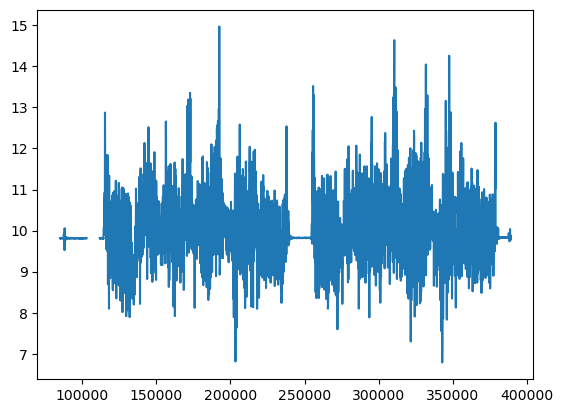

In [585]:
plt.plot(data_bad_1['timestamp(ms)'],data_bad_1['sqrt(IMU[0].AccX**2+IMU[0].AccY**2+IMU[0].AccZ**2)'])
plt.show()

In [586]:
def get_first_last_none_index(df, column_name):
    column = df[column_name]
    first_none_index = column.index[column.isnull()].min()
    last_none_index = column.index[column.isnull()].max()
    return first_none_index, last_none_index

def split_array(array, segment_size, overlap):
    splitted_segments = []
    i = 0
    while i < len(array):
        if len(array[i:i+segment_size]) == segment_size:
            splitted_segments.append(array[i:i+segment_size])
        i += segment_size - overlap
    return splitted_segments

def split_aggregation(array,first_segment,agg):
    splitted_segments = []
    i = 0
    while first_segment+agg*i < len(array):
        splitted_segments.append(array[:first_segment+agg*i])
        i += 1
    return splitted_segments

def get_acc(arr1,arr2,arr3):
    sum_of_squares = np.square(arr1) + np.square(arr2) + np.square(arr3)
    result = np.sqrt(sum_of_squares)
    return result

def normalization(data):
    min_data = min(data)
    diff_data = max(data) - min_data
    return [(x-min_data)/diff_data for x in data]

def FFT_data(data_array,df=True,vals=False):
    data_dict = {}
    signal_size = 500
    sample_rate = 1000
    fft_freq = rfftfreq(signal_size, d=1/sample_rate)
    if not vals:
        data_dict['Frequencies'] = fft_freq[5:]
        for index,data in enumerate(data_array):
            fft_val = abs(rfft(data,n=signal_size))
            data_dict[f'Sample {index+1}'] = normalization(fft_val[5:])
        if df:
            return pd.DataFrame.from_dict(data_dict)
        else:
            return data_dict
    if vals:
        data_dict['Frequencies'] = fft_freq[5:]
        for index,data in enumerate(data_array):
            fft_val = abs(rfft(data.values,n=signal_size))
            data_dict[f'Sample {index+1}'] = normalization(fft_val[5:])
        if df:
            return pd.DataFrame.from_dict(data_dict)
        else:
            return data_dict


In [587]:
data_15 = pd.read_csv('data/gyro_acc_lot_03_15.csv')
data_good_1 = pd.read_csv('data_new/lot_1_all_good.csv')
data_good_2 = pd.read_csv('data_new/lot_2_all_good.csv')
data_bad_1 = pd.read_csv('data_new/lot_3_not_good.csv')
data_bad_2 = pd.read_csv('data_new/lot_4_not_good.csv')

In [588]:
def clean_df(df, col_name,ranges, gyro_name=None):
    if gyro_name:
        x ='degrees(IMU[0].GyrX)'
        y ='degrees(IMU[0].GyrY)'
        z ='degrees(IMU[0].GyrZ)'
    else:
        x = 'IMU[0].GyrX'
        y = 'IMU[0].GyrY'
        z = 'IMU[0].GyrZ'

    if len(ranges) > 2:
        first, second, third, fourth = ranges
        time_1 = df['timestamp(ms)'].values[first:second] - min(df['timestamp(ms)'].values[first:second])
        time_2 = df['timestamp(ms)'].values[third:fourth] - min(df['timestamp(ms)'].values[third:fourth])
        acc1  = df['sqrt(IMU[0].AccX**2+IMU[0].AccY**2+IMU[0].AccZ**2)'].values[first:second]
        acc2  = df['sqrt(IMU[0].AccX**2+IMU[0].AccY**2+IMU[0].AccZ**2)'].values[third:fourth]

        x1 = df[x].values[first:second]
        x2 = df[x].values[third:fourth]
        y1 = df[y].values[first:second]
        y2 = df[y].values[third:fourth]
        z1 = df[z].values[first:second]
        z2 = df[z].values[third:fourth]

        gyro1 = get_acc(x1,y1,z1)
        gyro2 = get_acc(x2,y2,z2)
        df1 = pd.DataFrame(np.array([time_1,acc1,x1,y1,z1,gyro1]).T,columns=['time', 'accel', 'X','Y','Z','gyro'])
        df2 = pd.DataFrame(np.array([time_2,acc2,x2,y2,z2,gyro2]).T,columns=['time', 'accel', 'X','Y','Z','gyro'])
        return df1,df2

    else:
        first, second = ranges[0], ranges[1]
        time_1 = df['timestamp(ms)'].values[first:second] - min(df['timestamp(ms)'].values[first:second])
        acc1  = df['sqrt(IMU[0].AccX**2+IMU[0].AccY**2+IMU[0].AccZ**2)'].values[first:second]

        x1 = df[x].values[first:second]
        y1 = df[y].values[first:second]
        z1 = df[z].values[first:second]
        gyro1 = get_acc(x1,y1,z1)
        df1 = pd.DataFrame(np.array([time_1,acc1,x1,y1,z1,gyro1]).T,columns=['time', 'accel', 'X','Y','Z','gyro'])
        return df1

In [589]:
h1 = [600, 1750, 2850, 3900]
h2 = [10, 1228]
d1 = [300,1525,1700,2900]
d2 = [900,2100,2200,3430]
healthy1, healthy2 = clean_df(data_good_1,'degrees(IMU[0].GyrX)',h1,1)
healthy3 = clean_df(data_good_2,'IMU[0].GyrX',h2)
damage_35_1, damage_35_2 = clean_df(data_bad_1,'degrees(IMU[0].GyrX)',d1,1)
damage_35_3, damage_35_4 = clean_df(data_bad_2,'degrees(IMU[0].GyrX)',d2,1)

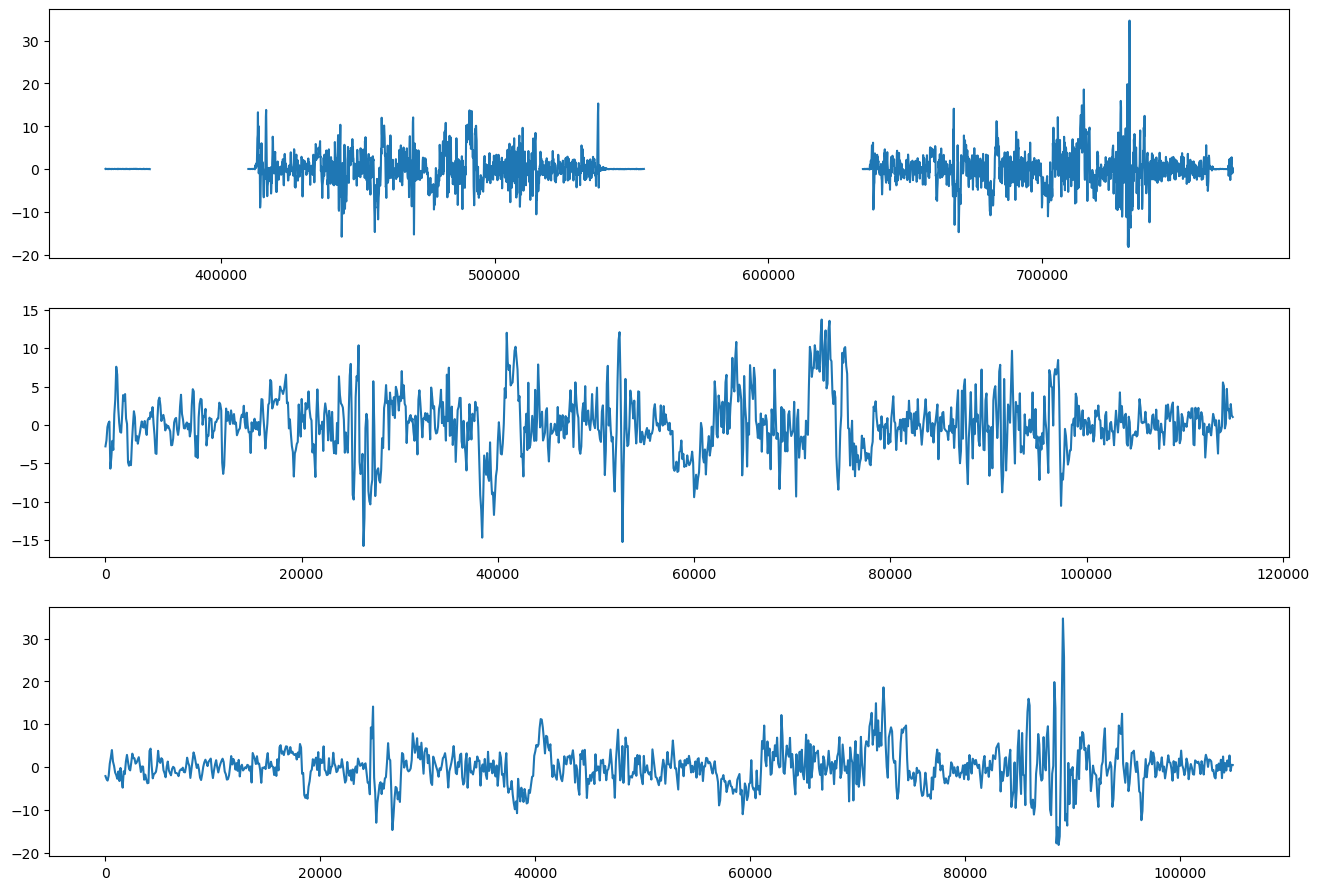

In [590]:
fig,ax = plt.subplots(3,1,figsize=[16,11])
ax[0].plot(data_good_1['timestamp(ms)'],data_good_1['degrees(IMU[0].GyrX)'])
ax[1].plot(healthy1['time'],healthy1['X'])
ax[2].plot(healthy2['time'],healthy2['X'])

---

In [591]:
# Get the first and last indices for data_15
first, second = get_first_last_none_index(data_15, 'IMU[0].AccY')

time_15 = data_15['timestamp(ms)'].values[second + 51:-190] - min(data_15['timestamp(ms)'].values[second + 51:-190])

acc_X_15 = data_15['IMU[0].AccX'].values[second + 51:-190]
acc_Y_15 = data_15['IMU[0].AccY'].values[second + 51:-190]
acc_Z_15 = data_15['IMU[0].AccZ'].values[second + 51:-190]
acc_15 = get_acc(acc_X_15, acc_Y_15, acc_Z_15)  # 50 190

gyro_X_15 = data_15['degrees(IMU[0].GyrX)'].values[second + 51:-190]
gyro_Y_15 = data_15['degrees(IMU[0].GyrY)'].values[second + 51:-190]
gyro_Z_15 = data_15['degrees(IMU[0].GyrZ)'].values[second + 51:-190]
gyro = get_acc(gyro_X_15, gyro_Y_15, gyro_Z_15)
damage_15 = pd.DataFrame(np.array([time_15,acc_15,gyro_X_15,gyro_Y_15,gyro_Z_15,gyro]).T,columns=['time', 'accel', 'X','Y','Z','gyro'])


In [592]:
damage_15.to_csv('data_new_preprocessed/damaged15.csv')
healthy1.to_csv('data_new_preprocessed/healthy1.csv')
healthy2.to_csv('data_new_preprocessed/healthy2.csv')
healthy3.to_csv('data_new_preprocessed/healthy3.csv')
damage_35_1.to_csv('data_new_preprocessed/damaged35_1.csv')
damage_35_2.to_csv('data_new_preprocessed/damaged35_2.csv')
damage_35_3.to_csv('data_new_preprocessed/damaged35_3.csv')
damage_35_4.to_csv('data_new_preprocessed/damaged35_4.csv')

---
Comparing acceleration signals after drone takeoff with different rotor blade conditions.

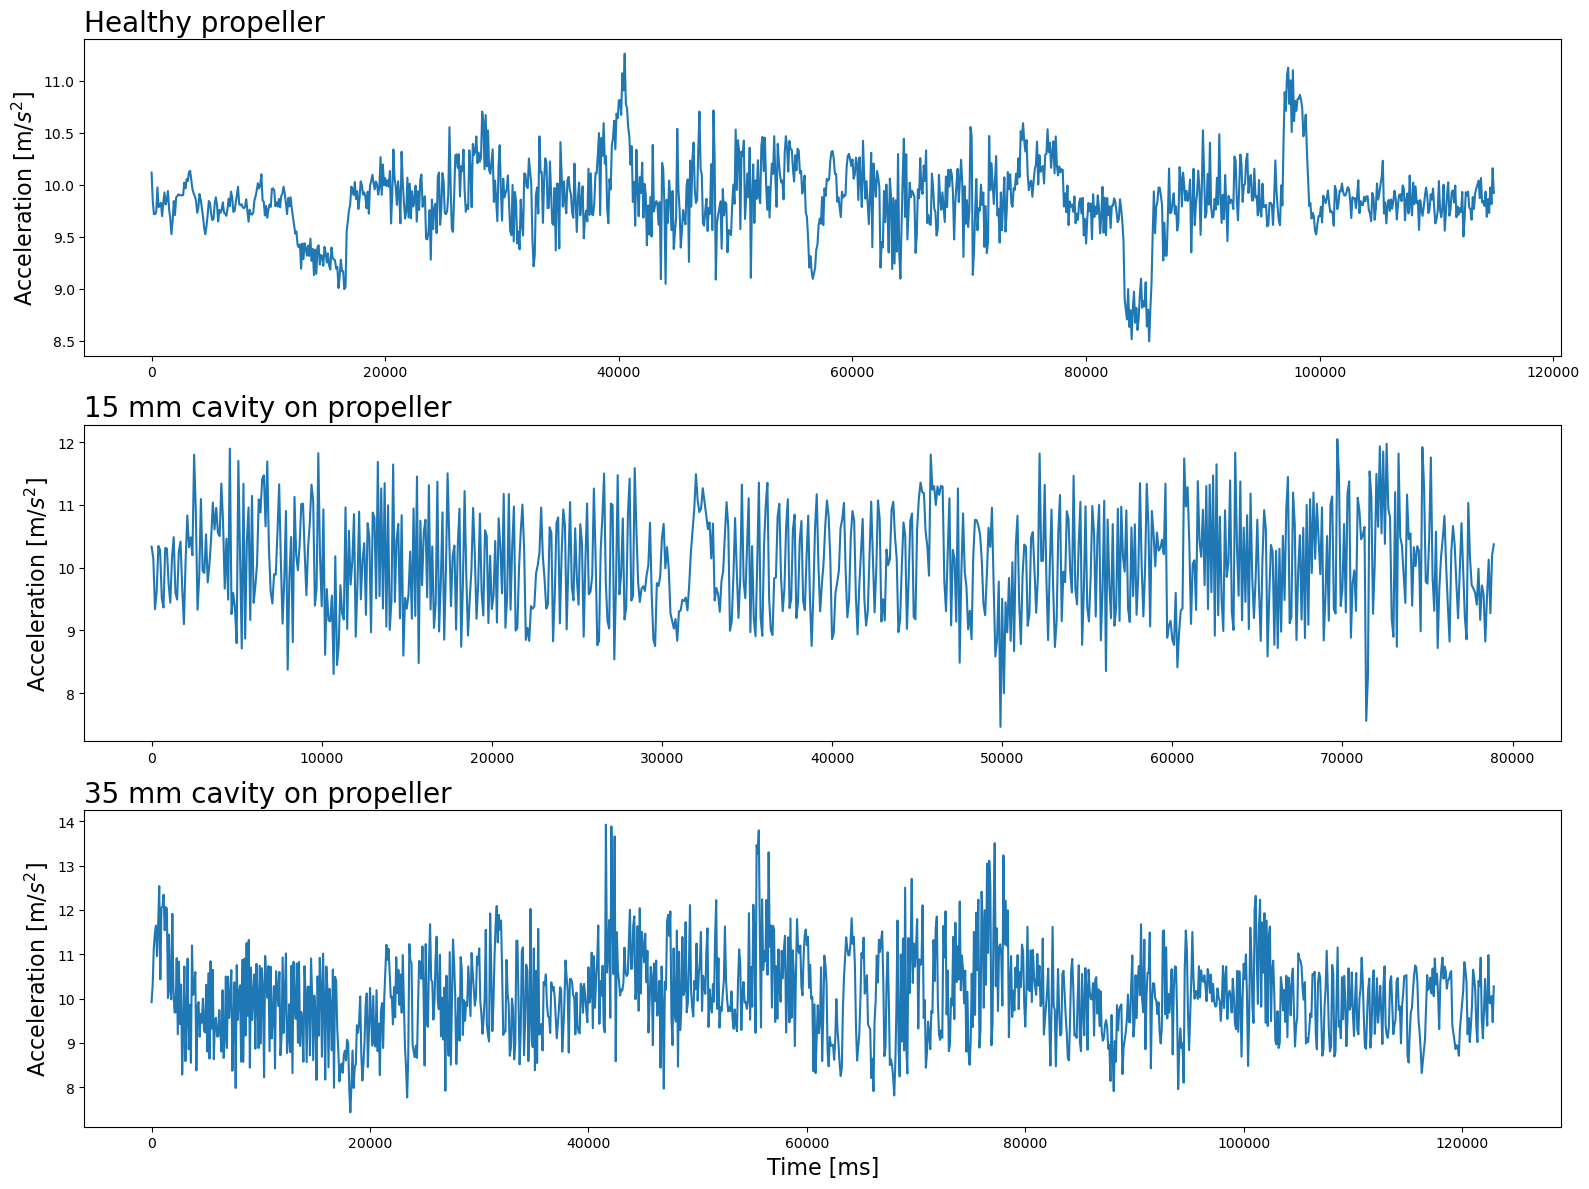

In [612]:
fig,ax = plt.subplots(3,1,figsize=[16,12],tight_layout=True)

ax[0].plot(healthy1['time'], healthy1['accel'], label='Acc_healthy')
ax[1].plot(damage_15['time'], damage_15['accel'], label='Acc_damaged')
ax[2].plot(damage_35_4['time'], damage_35_4['accel'], label='Acc_very_damaged')

ax[0].set_ylabel('Acceleration [m/$s^2$]',fontsize=16)
ax[1].set_ylabel('Acceleration [m/$s^2$]',fontsize=16)
ax[2].set_ylabel('Acceleration [m/$s^2$]',fontsize=16)
ax[2].set_xlabel('Time [ms]',fontsize=16)
ax[0].set_title('Healthy propeller',fontsize=20,loc='left')
ax[1].set_title('15 mm cavity on propeller',fontsize=20,loc='left')
ax[2].set_title('35 mm cavity on propeller',fontsize=20,loc='left')

plt.savefig('photos/data_from_acc_1.png')
plt.show()

In [594]:
acc_healthy_split1 = split_array(healthy1['accel'],175,125)
acc_healthy_split2 = split_array(healthy2['accel'],175,125)
acc_healthy_split3 = split_array(healthy3['accel'],175,125)
acc_healthy_split = np.concatenate([acc_healthy_split1,acc_healthy_split2,acc_healthy_split3])

In [595]:
acc_35_split1 = split_array(damage_35_1['accel'],175,125)
acc_35_split2 = split_array(damage_35_2['accel'],175,125)
acc_35_split3 = split_array(damage_35_3['accel'],175,125)
acc_35_split4 = split_array(damage_35_4['accel'],175,125)
acc_35_split = np.concatenate([acc_35_split1,acc_35_split2,acc_35_split3,acc_35_split4])

In [596]:
acc_15_split = split_array(damage_15['accel'],175,125)
acc_15_split = np.concatenate([acc_15_split])

In [597]:
columns_h = [f'Sample {x}' for x in range(len(acc_healthy_split))]
columns_15 = [f'Sample {x}' for x in range(len(acc_15_split))]
columns_35 = [f'Sample {x}' for x in range(len(acc_35_split))]

In [598]:
data_healthy = pd.DataFrame(acc_healthy_split).T
data_15 = pd.DataFrame(acc_15_split).T
data_35 = pd.DataFrame(acc_35_split).T
data_healthy.columns = columns_h
data_15.columns = columns_15
data_35.columns = columns_35

In [599]:
data_15

,Sample 0,Sample 1,Sample 2,Sample 3,Sample 4,Sample 5,Sample 6,Sample 7,Sample 8,Sample 9,Sample 10,Sample 11,Sample 12
0,10.334656,8.796680,9.384295,9.346721,9.341136,9.824245,10.475741,10.325769,8.861330,10.610720,9.503888,9.376936,8.857599
1,10.152722,11.702860,10.930658,9.560050,9.554548,9.409622,10.698262,11.107896,8.957280,11.093576,7.996293,9.142793,8.767636
2,9.338249,10.195951,8.611182,10.256743,10.425434,10.693271,9.990320,8.972305,9.595930,11.358250,9.447432,9.837896,9.597562
3,9.624544,8.710529,9.658780,9.187234,9.124484,10.388265,10.328231,10.344024,9.756776,11.205204,8.967639,10.984010,8.410262
4,10.345658,11.337108,9.159688,10.944942,10.788280,8.899470,9.977100,9.189335,9.947605,11.187698,9.835688,10.560054,8.970805
...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,9.756545,8.847466,11.022796,11.490678,9.857366,9.076048,9.079520,9.280929,10.973273,11.302498,9.213593,11.495383,10.710150
171,10.882735,9.039230,10.999008,11.073536,9.305798,9.298678,10.282633,9.847287,10.186968,9.341520,11.198222,10.653097,9.967203
172,8.851719,8.832076,8.536669,10.887132,9.672841,10.179680,10.141242,11.820913,9.936798,11.325713,10.684725,11.935451,9.207908
173,9.932512,9.387258,9.735599,10.941359,10.651108,11.053202,9.141383,10.107112,10.914900,9.609246,8.846519,10.547789,8.857664


---
Save accelerometer data in the time domain.

In [600]:
data_healthy.to_csv('data_new_preprocessed/acc_healthy_samples.csv')
data_15.to_csv('data_new_preprocessed/acc_15_samples.csv')
data_35.to_csv('data_new_preprocessed/acc_35_samples.csv')

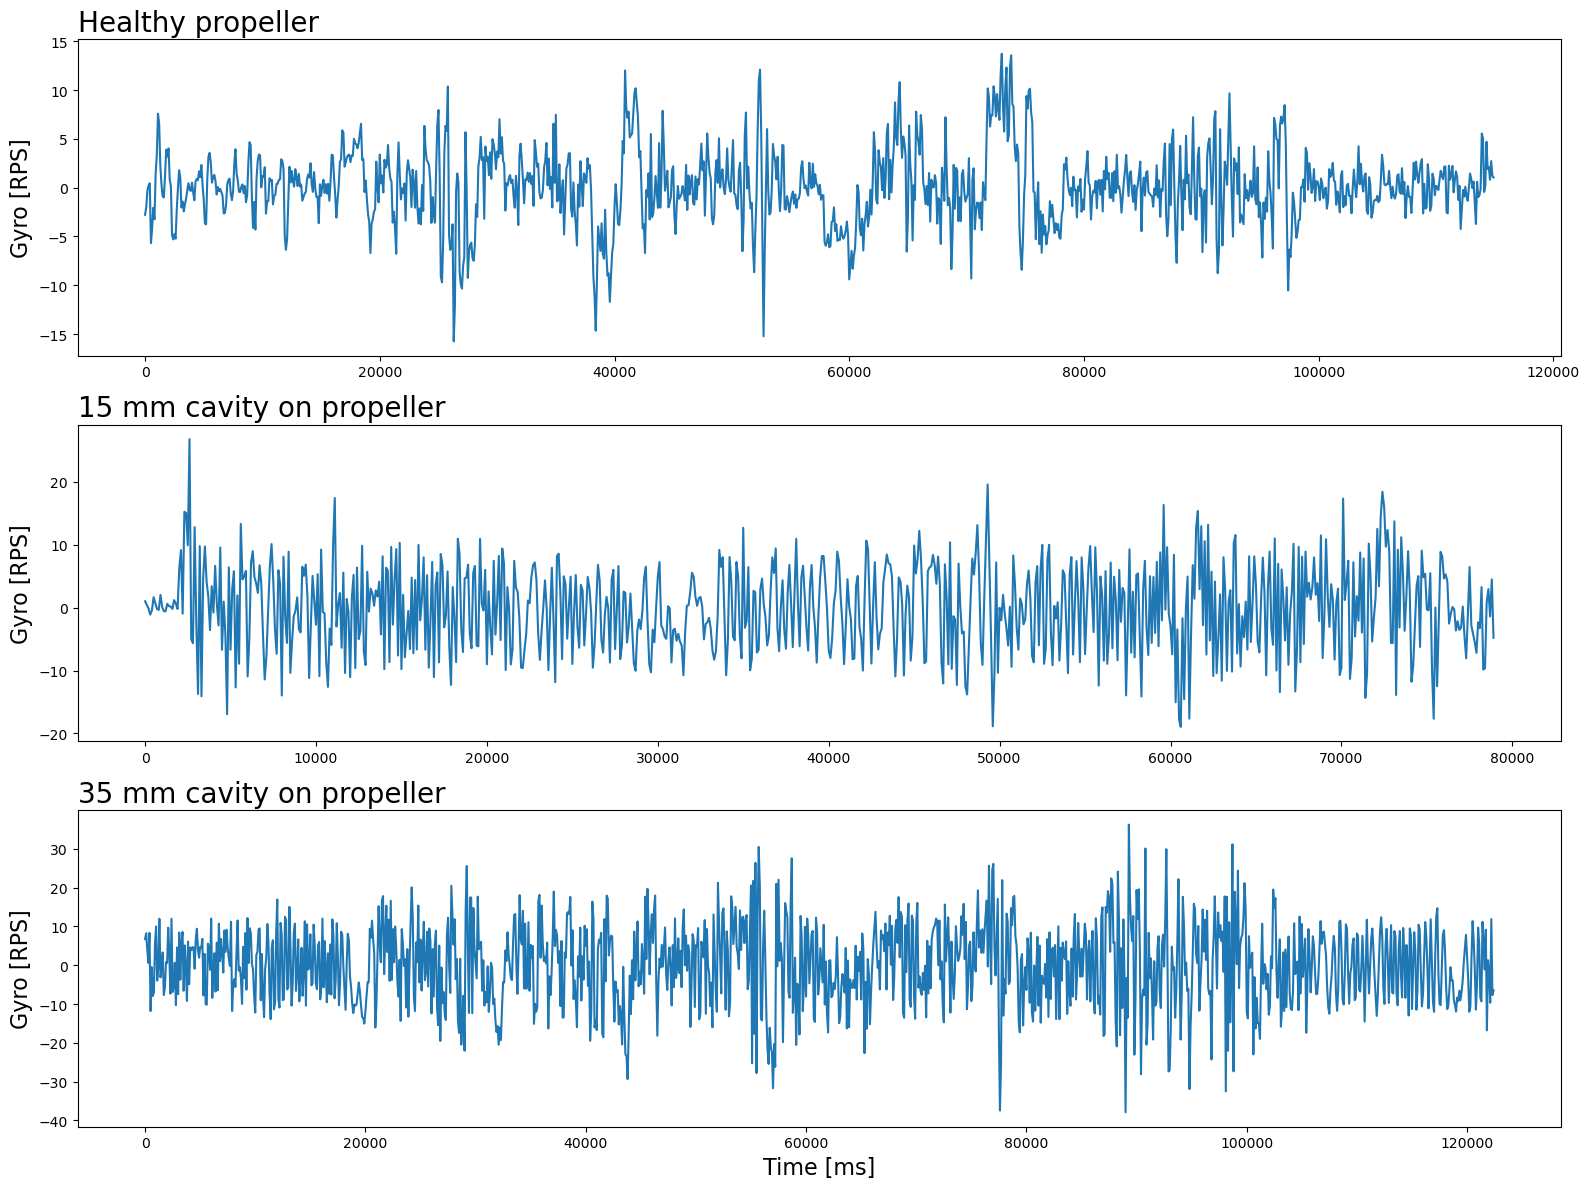

In [613]:
fig,ax = plt.subplots(3,1,figsize=[16,12],tight_layout=True)

ax[0].plot(healthy1['time'], healthy1['X'])
ax[1].plot(damage_15['time'], damage_15['X'])
ax[2].plot(damage_35_1['time'],damage_35_1['X'])
ax[0].set_title('Healthy propeller',fontsize=20,loc='left')
ax[1].set_title('15 mm cavity on propeller',fontsize=20,loc='left')
ax[2].set_title('35 mm cavity on propeller',fontsize=20,loc='left')

ax[0].set_ylabel('Gyro [RPS]',fontsize=16)
ax[1].set_ylabel('Gyro [RPS]',fontsize=16)
ax[2].set_ylabel('Gyro [RPS]',fontsize=16)
ax[2].set_xlabel('Time [ms]',fontsize=16)
plt.savefig('photos/gyro_3.png')
plt.show()

---
Performing Fourier transform to obtain gyroscope data in the frequency domain.

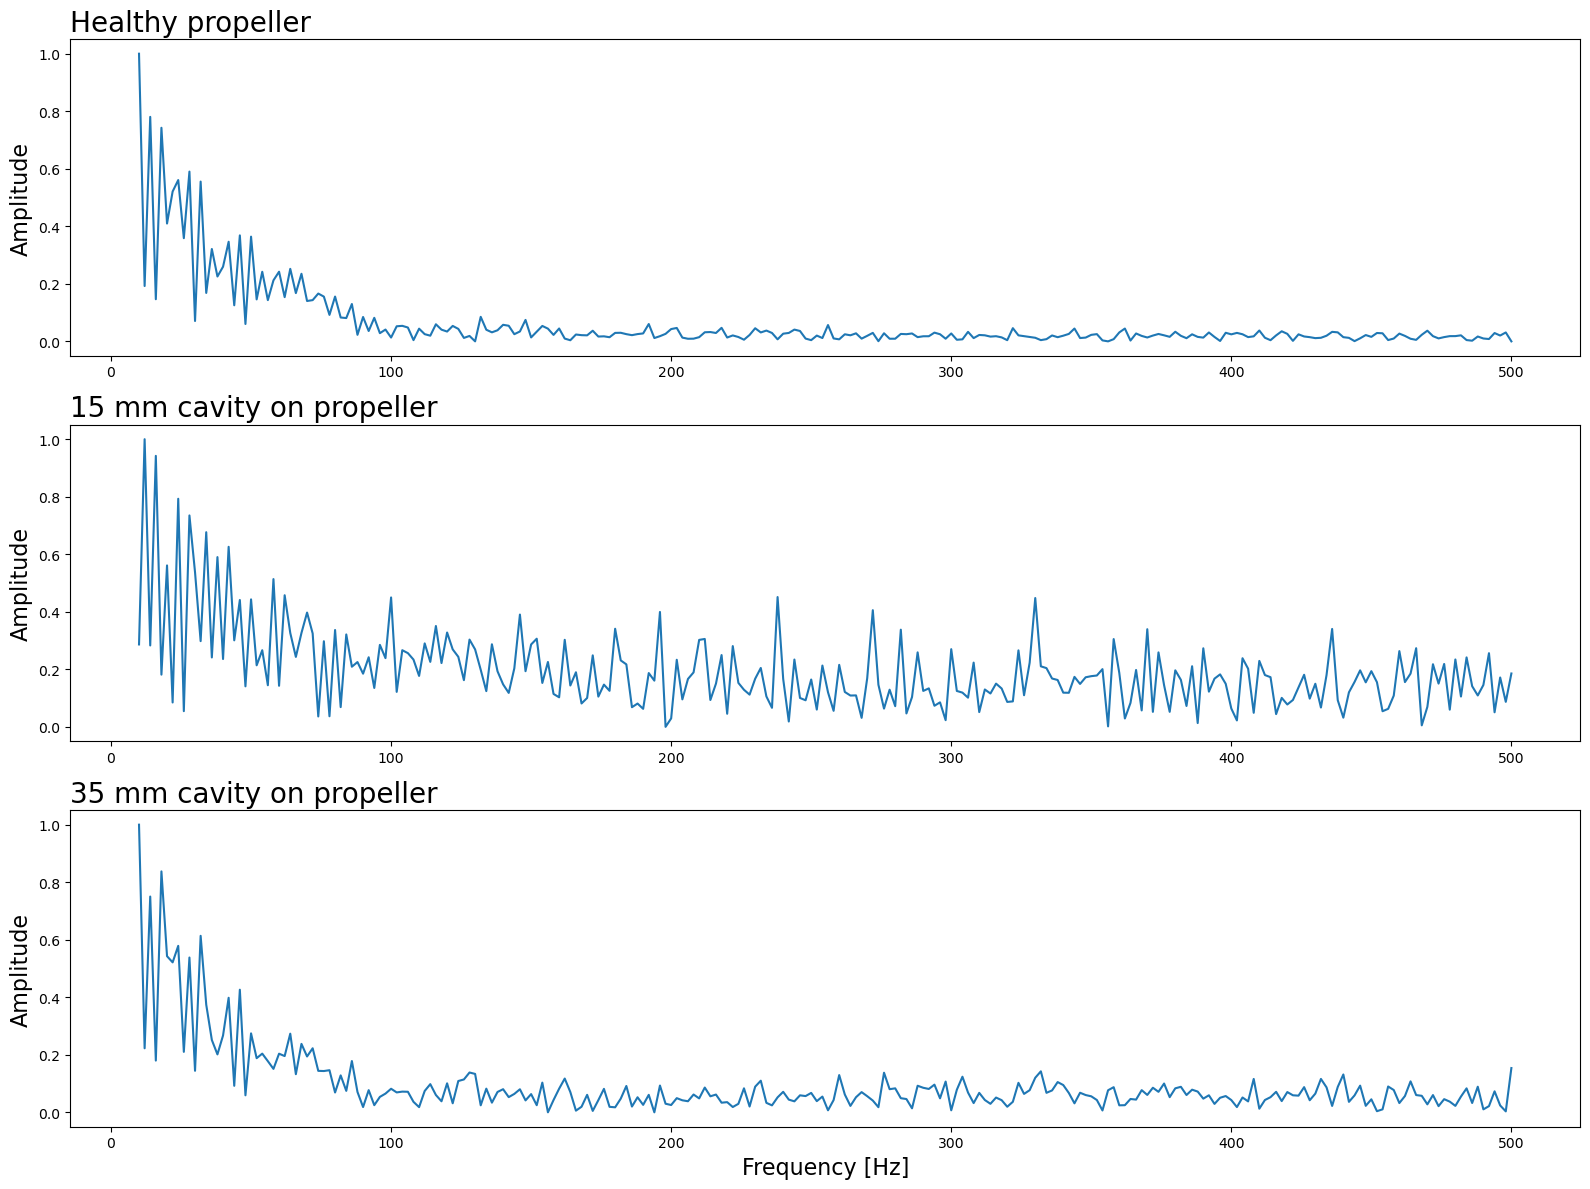

251

In [614]:
fft_val_h = abs(rfft(healthy1['gyro'].values,n=500))
fft_freq_h = rfftfreq(500,d=1/1000)

fft_val_15 = abs(rfft(damage_15['gyro'].values,n=500))
fft_freq_15 = rfftfreq(500,d=1/1000)

fft_val_35 = abs(rfft(damage_35_1['gyro'].values,n=500))
fft_freq_35 = rfftfreq(500,d=1/1000)

fig,ax = plt.subplots(3,1,figsize=[16,12],tight_layout=True)
ax[0].plot(fft_freq_h[5:], normalization(fft_val_h[5:]), label='gyro_healthy')
ax[1].plot(fft_freq_15[5:], normalization(fft_val_15[5:]), label='gyro_damaged')
ax[2].plot(fft_freq_35[5:],normalization(fft_val_35[5:]),label='gyro_very_damaged')
ax[0].set_title('Healthy propeller',fontsize=20,loc='left')
ax[1].set_title('15 mm cavity on propeller',fontsize=20,loc='left')
ax[2].set_title('35 mm cavity on propeller',fontsize=20,loc='left')
ax[0].set_ylabel('Amplitude',fontsize=16)
ax[1].set_ylabel('Amplitude',fontsize=16)
ax[2].set_ylabel('Amplitude',fontsize=16)

ax[2].set_xlabel('Frequency [Hz]',fontsize=16)
plt.show()
len(fft_freq_15)

In [603]:
gyro_35_split1 = split_array(damage_35_1['gyro'],175,125)
gyro_35_split2 = split_array(damage_35_2['gyro'],175,125)
gyro_35_split3 = split_array(damage_35_3['gyro'],175,125)
gyro_35_split4 = split_array(damage_35_4['gyro'],175,125)
gyro_35_split = np.concatenate([gyro_35_split1,gyro_35_split2,gyro_35_split3,gyro_35_split4])

gyro_healthy_split1 = split_array(healthy1['gyro'],175,125)
gyro_healthy_split2 = split_array(healthy2['gyro'],175,125)
gyro_healthy_split3 = split_array(healthy3['gyro'],175,125)
gyro_healthy_split = np.concatenate([gyro_healthy_split1,gyro_healthy_split2,gyro_healthy_split3])

gyro_15_split = split_array(damage_15['gyro'],175,125)
gyro_15_split = np.concatenate([gyro_15_split])

---
Save gyroscope data in the frequency domain.

In [604]:
df_gyro_healthy = FFT_data(gyro_healthy_split)
df_gyro_15 = FFT_data(gyro_15_split)
df_gyro_35 = FFT_data(gyro_35_split)

df_gyro_healthy.to_csv('data_new_preprocessed/gyro_healthy_samples.csv')
df_gyro_15.to_csv('data_new_preprocessed/gyro_15_samples.csv')
df_gyro_35.to_csv('data_new_preprocessed/gyro_35_samples.csv')

In [605]:
df_gyro_healthy.head()

,Frequencies,Sample 1,Sample 2,Sample 3,Sample 4,Sample 5,Sample 6,Sample 7,Sample 8,Sample 9,...,Sample 50,Sample 51,Sample 52,Sample 53,Sample 54,Sample 55,Sample 56,Sample 57,Sample 58,Sample 59
0,10.0,0.577916,1.000000,0.705093,1.000000,0.746753,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.710249,1.000000,1.000000,0.621887,1.000000,0.418288,1.000000,0.369093,1.000000
1,12.0,0.926315,0.880191,0.948280,0.808328,1.000000,0.473984,0.979473,0.724691,0.794004,...,0.319688,0.201322,0.378995,0.517305,0.656977,0.484258,0.832521,0.751559,0.795315,0.680068
2,14.0,1.000000,0.824743,1.000000,0.518314,0.962724,0.737137,0.874985,0.528507,0.730939,...,0.778181,0.591975,0.765105,0.833978,1.000000,0.587649,1.000000,0.295578,1.000000,0.541564
3,16.0,0.127937,0.774089,0.843135,0.434537,0.576138,0.861570,0.742664,0.611719,0.715931,...,0.475847,0.177469,0.567114,0.884411,0.412870,0.438180,0.709306,0.092801,0.736588,0.297864
4,18.0,0.758927,0.682846,0.621443,0.563205,0.268599,0.654143,0.703672,0.714515,0.799543,...,0.181484,0.622836,0.381453,0.673864,0.341364,0.097606,0.267683,0.201833,0.433503,0.067673


Text(0.5, 0, 'Frequency [Hz]')

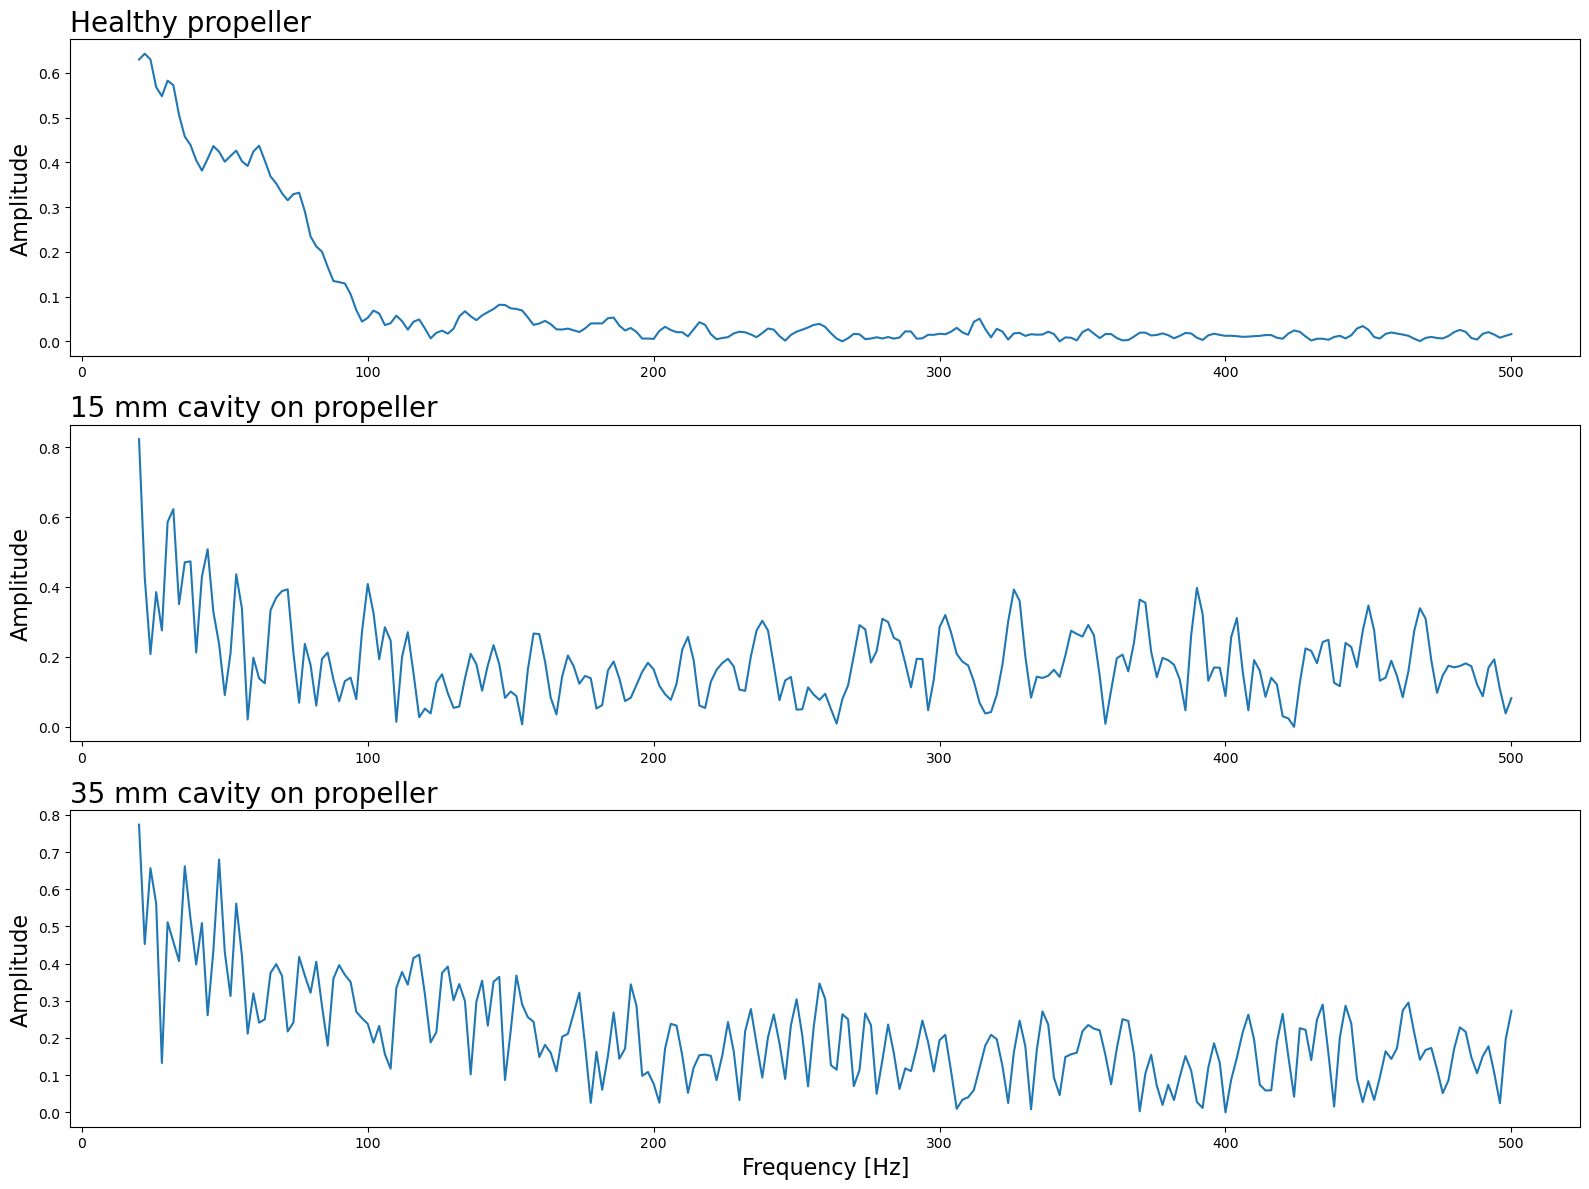

In [615]:
freq = df_gyro_healthy['Frequencies'][5:]
samples_1 = [x for x in df_gyro_healthy.columns if 'Sample' in x]
samples_2 = [x for x in df_gyro_15.columns if 'Sample' in x]
samples_3 = [x for x in df_gyro_35.columns if 'Sample' in x]

fig,ax = plt.subplots(3,1,figsize=[16,12],tight_layout=True)
for col in samples_1[1:2]:
    ax[0].plot(freq,df_gyro_healthy[col][5:])
    ax[0].set_title('Healthy propeller',fontsize=20,loc='left')
for col in samples_2[1:2]:
    ax[1].plot(freq,df_gyro_15[col][5:])
    ax[1].set_title('15 mm cavity on propeller',fontsize=20,loc='left')
for col in samples_3[1:2]:
    ax[2].plot(freq,df_gyro_35[col][5:])
    ax[2].set_title('35 mm cavity on propeller',fontsize=20,loc='left')
    
ax[0].set_ylabel('Amplitude',fontsize=16)
ax[1].set_ylabel('Amplitude',fontsize=16)
ax[2].set_ylabel('Amplitude',fontsize=16)
ax[2].set_xlabel('Frequency [Hz]', fontsize=16)


In [607]:
gyro_35_split1 = split_aggregation(damage_35_1['gyro'],175,50)
gyro_35_split2 = split_aggregation(damage_35_2['gyro'],175,50)
gyro_35_split3 = split_aggregation(damage_35_3['gyro'],175,50)
gyro_35_split4 = split_aggregation(damage_35_4['gyro'],175,50)
gyro_35_splitagg = np.concatenate([gyro_35_split1,gyro_35_split2,gyro_35_split3,gyro_35_split4])

gyro_healthy_split1 = split_aggregation(healthy1['gyro'],175,50)
gyro_healthy_split2 = split_aggregation(healthy2['gyro'],175,50)
gyro_healthy_split3 = split_aggregation(healthy3['gyro'],175,50)
gyro_healthy_splitagg = np.concatenate([gyro_healthy_split1,gyro_healthy_split2,gyro_healthy_split3])

gyro_15_split = split_aggregation(damage_15['gyro'],175,50)
gyro_15_splitagg = np.concatenate([gyro_15_split])

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [618]:
df_gyro_healthy_splitagg = FFT_data(gyro_healthy_splitagg,1,1)
df_gyro_15_splitagg = FFT_data(gyro_15_splitagg,1,1)
df_gyro_35_splitagg = FFT_data(gyro_35_splitagg,1,1)


df_gyro_healthy_splitagg.to_csv('data_new_preprocessed/gyro_agg_healthy_samples.csv') 
df_gyro_15_splitagg.to_csv('data_new_preprocessed/gyro_agg_15_samples.csv')
df_gyro_35_splitagg.to_csv('data_new_preprocessed/gyro_agg_35_samples.csv')


In [609]:
df_gyro_healthy_splitagg

,Frequencies,Sample 1,Sample 2,Sample 3,Sample 4,Sample 5,Sample 6,Sample 7,Sample 8,Sample 9,...,Sample 50,Sample 51,Sample 52,Sample 53,Sample 54,Sample 55,Sample 56,Sample 57,Sample 58,Sample 59
0,10.0,0.577916,0.967114,0.676621,1.000000,0.912744,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,12.0,0.926315,1.000000,1.000000,0.917327,1.000000,0.176473,0.207006,0.192424,0.192424,...,0.206161,0.206161,0.206161,0.206161,0.206161,0.206161,0.206161,0.206161,0.206161,0.206161
2,14.0,1.000000,0.783170,0.896902,0.509641,0.444035,0.790932,0.811712,0.780463,0.780463,...,0.927204,0.927204,0.927204,0.927204,0.927204,0.927204,0.927204,0.927204,0.927204,0.927204
3,16.0,0.127937,0.772292,0.814228,0.465331,0.464364,0.206461,0.208397,0.146518,0.146518,...,0.356104,0.356104,0.356104,0.356104,0.356104,0.356104,0.356104,0.356104,0.356104,0.356104
4,18.0,0.758927,0.734702,0.635459,0.634863,0.612072,0.782924,0.840390,0.742551,0.742551,...,0.971574,0.971574,0.971574,0.971574,0.971574,0.971574,0.971574,0.971574,0.971574,0.971574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,492.0,0.050096,0.020646,0.011226,0.021495,0.031504,0.017682,0.021108,0.008172,0.008172,...,0.020896,0.020896,0.020896,0.020896,0.020896,0.020896,0.020896,0.020896,0.020896,0.020896
242,494.0,0.014393,0.016234,0.020093,0.010485,0.027139,0.011810,0.026091,0.028949,0.028949,...,0.018404,0.018404,0.018404,0.018404,0.018404,0.018404,0.018404,0.018404,0.018404,0.018404
243,496.0,0.000000,0.010394,0.022942,0.007698,0.002626,0.000000,0.012555,0.020286,0.020286,...,0.008379,0.008379,0.008379,0.008379,0.008379,0.008379,0.008379,0.008379,0.008379,0.008379
244,498.0,0.056318,0.011718,0.022758,0.013615,0.016694,0.008366,0.019751,0.031034,0.031034,...,0.019290,0.019290,0.019290,0.019290,0.019290,0.019290,0.019290,0.019290,0.019290,0.019290


---
Save gyroscope data in the frequency domain, but it has aggregated data from previous.


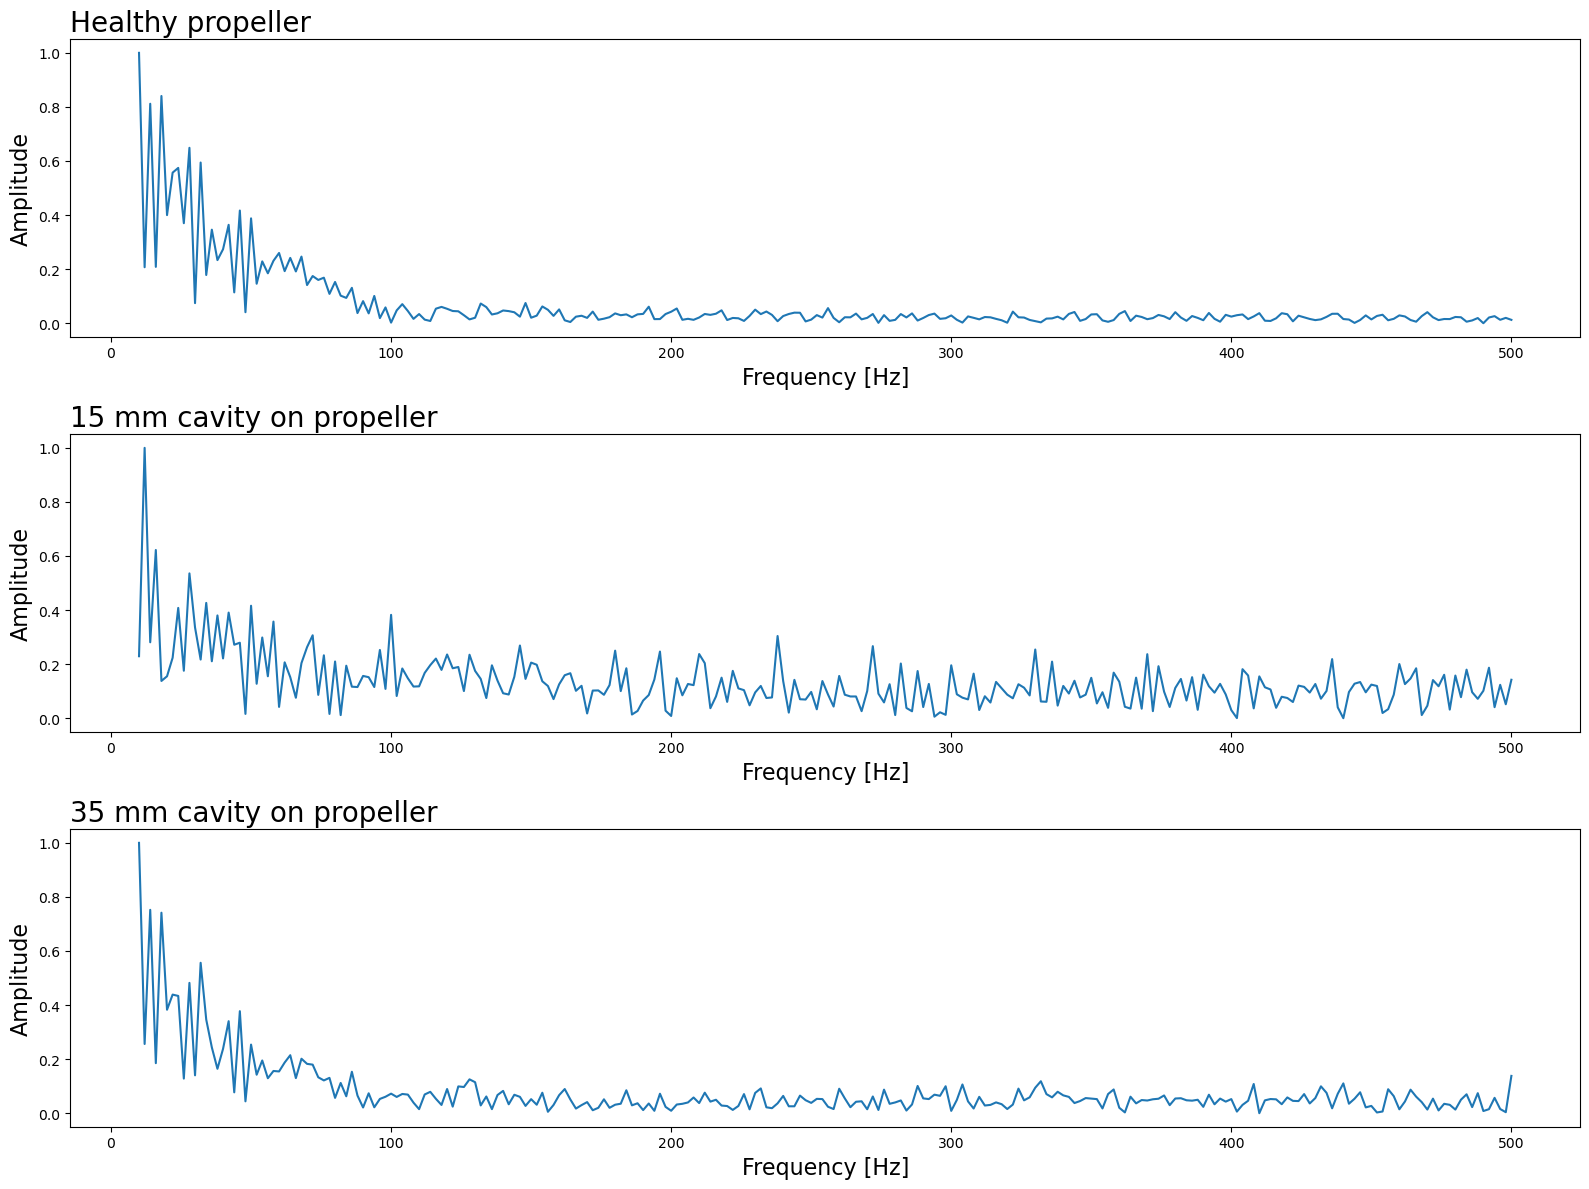

In [617]:
freq = df_gyro_15['Frequencies']

samples_1 = [x for x in df_gyro_healthy_splitagg.keys() if 'Sample' in x]
samples_2 = [x for x in df_gyro_15_splitagg.keys() if 'Sample' in x]
samples_3 = [x for x in df_gyro_35_splitagg.keys() if 'Sample' in x]

fig,ax = plt.subplots(3,1,figsize=[16,12],tight_layout=True)

for col in samples_1[6:7]:
    ax[0].plot(freq, df_gyro_healthy_splitagg[col])
    ax[0].set_title('Healthy propeller', fontsize=20,loc='left')

for col in samples_2[6:7]:
    ax[1].plot(freq, df_gyro_15_splitagg[col])
    ax[1].set_title('15 mm cavity on propeller', fontsize=20,loc='left')

for col in samples_3[6:7]:
    ax[2].plot(freq, df_gyro_35_splitagg[col])
    ax[2].set_title('35 mm cavity on propeller', fontsize=20,loc='left')



ax[0].set_ylabel('Amplitude', fontsize=16)
ax[1].set_ylabel('Amplitude', fontsize=16)
ax[2].set_ylabel('Amplitude', fontsize=16)

ax[0].set_xlabel('Frequency [Hz]', fontsize=16)
ax[1].set_xlabel('Frequency [Hz]', fontsize=16)
ax[2].set_xlabel('Frequency [Hz]', fontsize=16)
plt.savefig('photos/gyro_fft_500_1.png')
plt.show()

